Importing plotly failed. Interactive plots will not work.


ANALISIS PREDIKSI TREN PENJUALAN & PREFERENSI KONSUMEN 2020-2026

[TAHAP 1] MEMUAT DAN PREPROCESSING DATA

 Data loaded and preprocessed successfully
 Total transactions: 1,000,000
 Period: 2020-2025
 Products: 15 | Brands: 8 | Types: 8
 Features: 34 columns

   INTERPRETASI PREPROCESSING:

Data preprocessing mencakup:
• Penggabungan 4 dataset (sales, products, marketing, reviews)
• Feature engineering: time-based features, business metrics, lifecycle stages
• Rolling averages untuk menangkap tren jangka pendek
• Handling missing values dengan median/mode imputation

Dataset final berisi 1,000,000 transaksi dari 15 produk 
selama periode 2020-2025. Data siap untuk analisis mendalam.


[TAHAP 2] ANALISIS DESKRIPTIF (EDA)

   KEY PERFORMANCE INDICATORS:
  Total Revenue: Rp 121,309,698,437 (121.31B)
  Total Units Sold: 4,001,974 (4.00M units)
  Total Transactions: 1,000,000
  Total Profit: Rp -8,329,185,563
  Profit Margin: -6.87%
  Avg Transaction Value: Rp 121,310

   INTERPRETASI KPI:


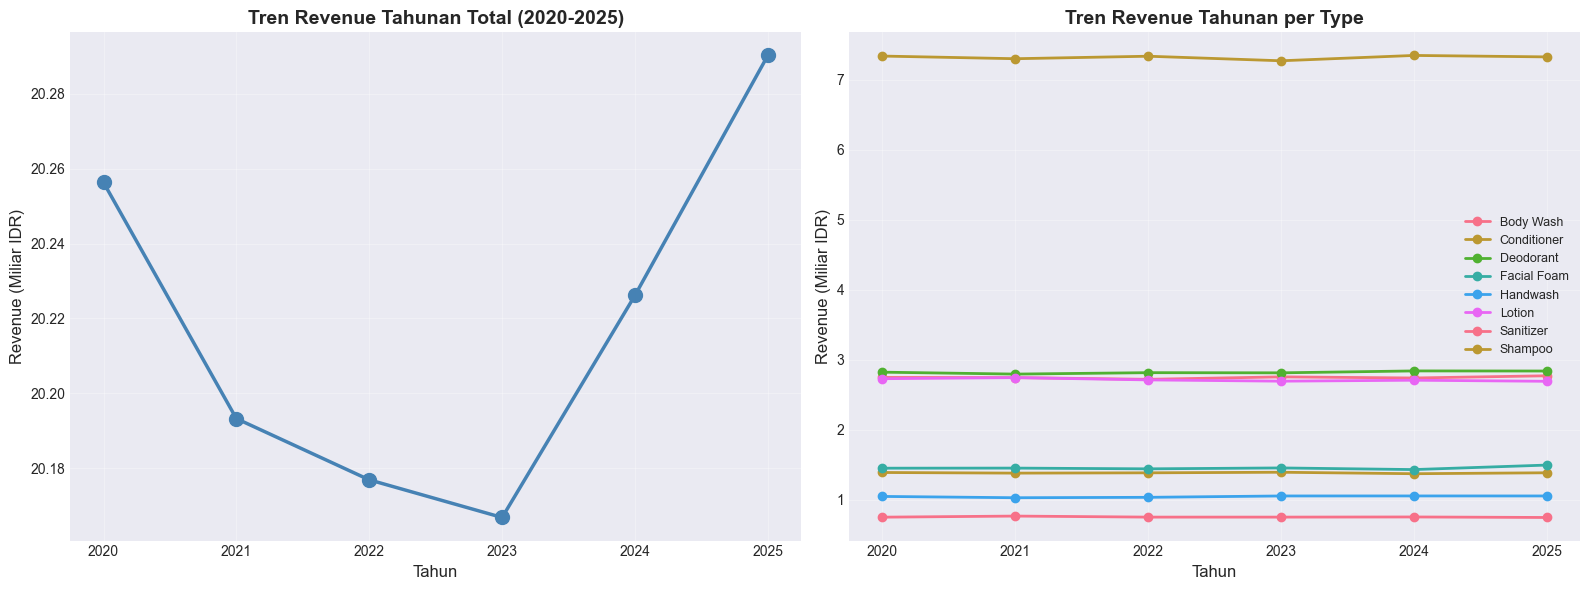


   INTERPRETASI VISUALISASI YEARLY TREND:

Grafik kiri menunjukkan tren revenue total dari tahun ke tahun.
Grafik kanan memecah tren per kategori produk untuk identifikasi:
• Kategori dengan pertumbuhan tercepat (opportunity untuk investment)
• Kategori yang stagnant/declining (perlu intervention atau phase-out)
• Seasonal patterns dan market cycles

Pattern yang terlihat:
- Pertumbuhan konsisten (upward trend)
- Beberapa kategori outperform yang lain (diversified growth)


   Creating monthly trend visualization...


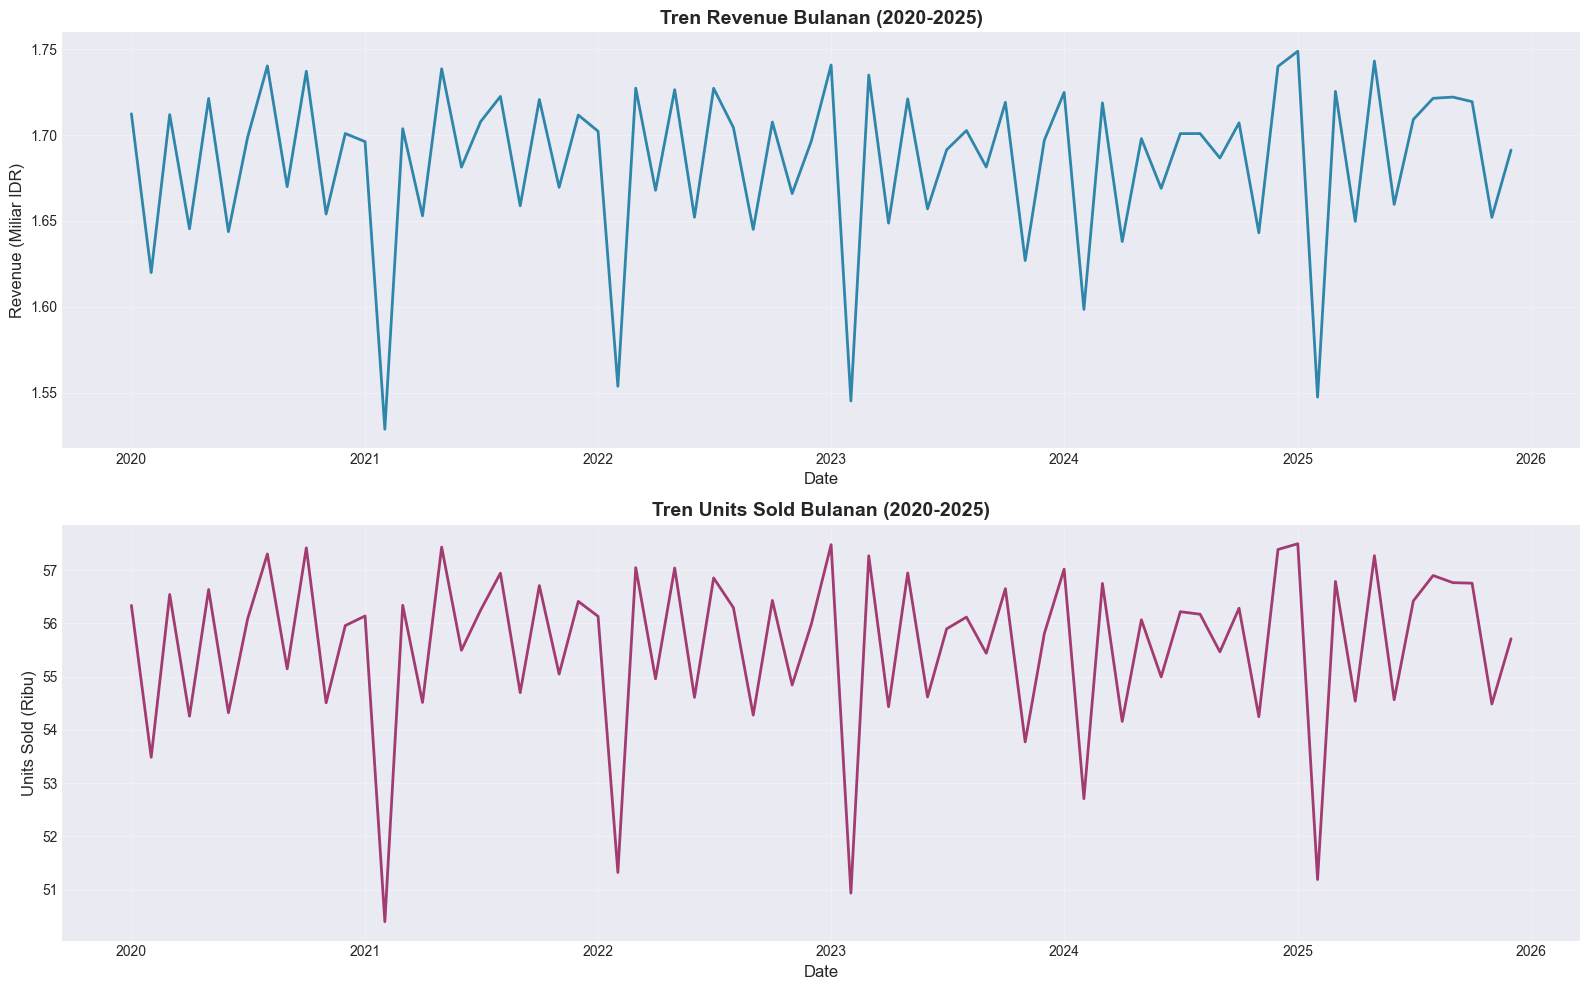


   INTERPRETASI MONTHLY TREND:

Tren bulanan menunjukkan:
• Peak sales di: January 2025 (holiday season, campaign besar, atau back-to-school)
• Lowest sales di: February 2021 (post-holiday slump atau low season)
• Seasonal patterns yang konsisten = predictable untuk inventory planning

Actionable insights:
- Prepare extra inventory untuk peak months
- Run promotions di low months untuk smooth demand
- Align marketing spend dengan demand cycles


[TAHAP 4] PREDIKSI TAHUNAN PER PRODUK (2026)

 Performa Model Prediksi Tahunan:
  MAE: 176.67 unit
  R² Score: 0.7582

 Visualisasi Prediksi Tahunan per Produk...


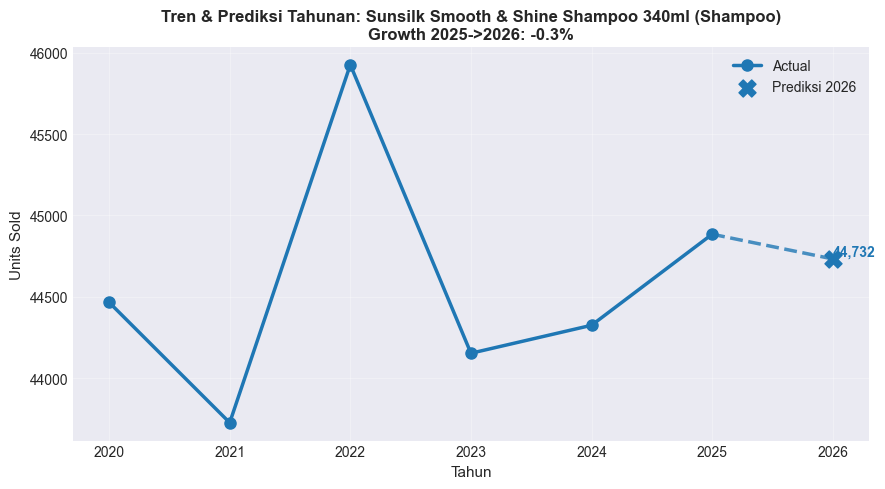

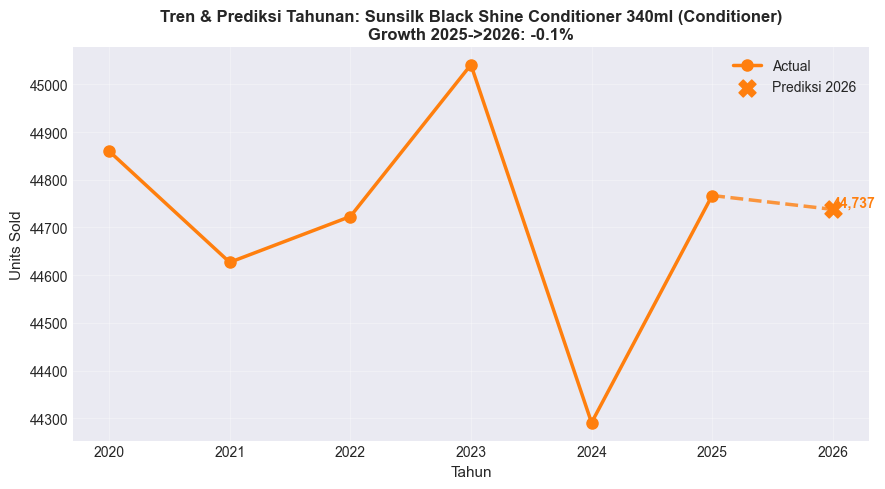

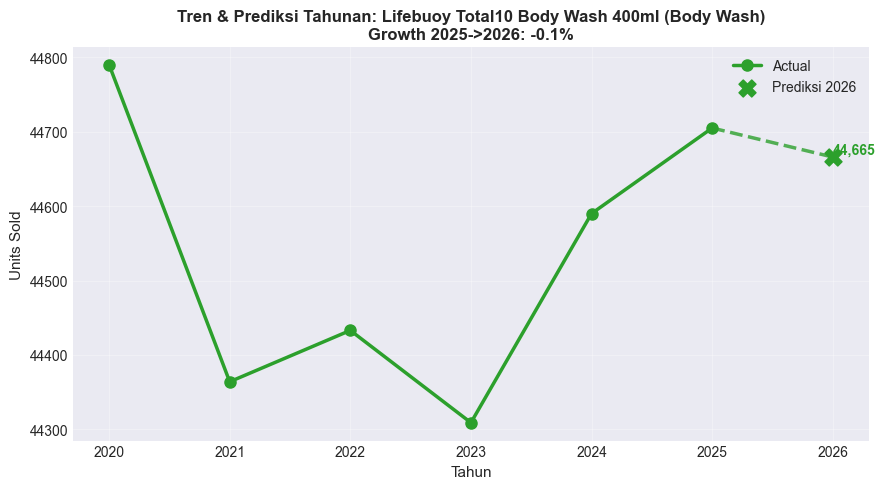

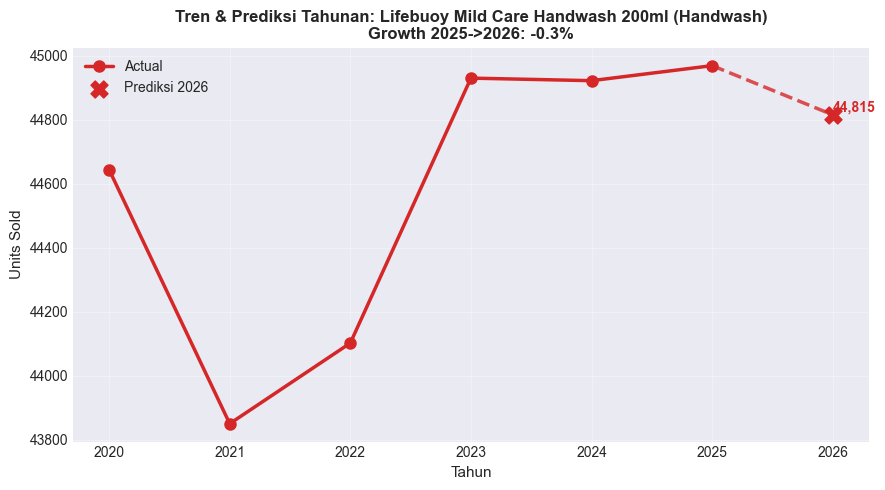

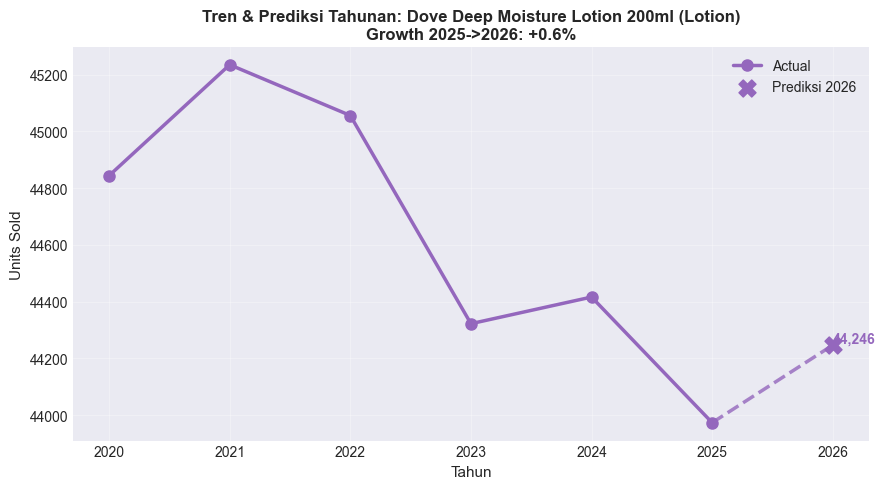

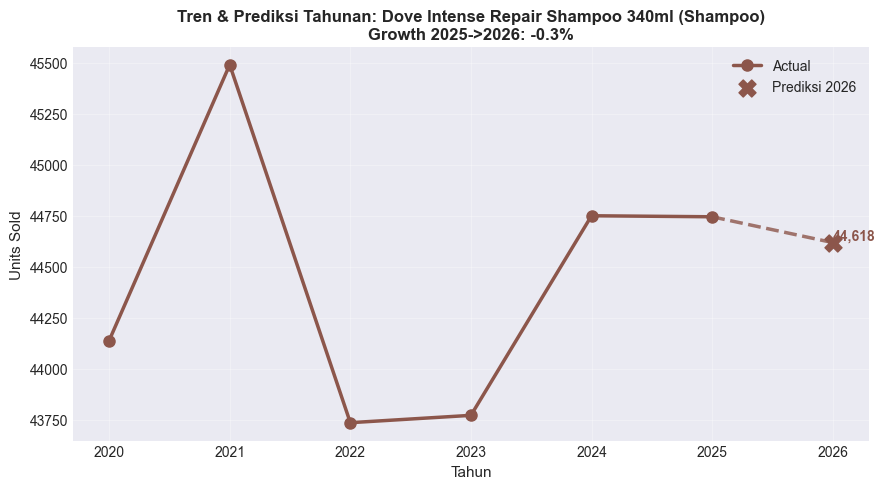

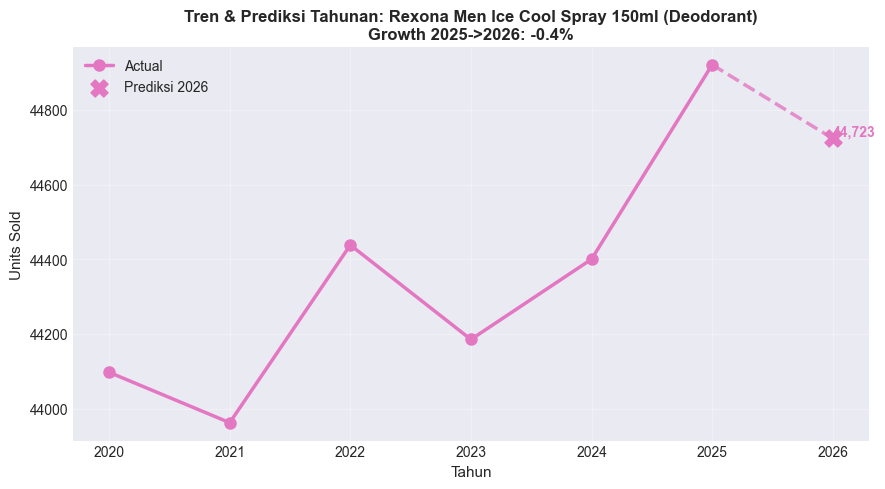

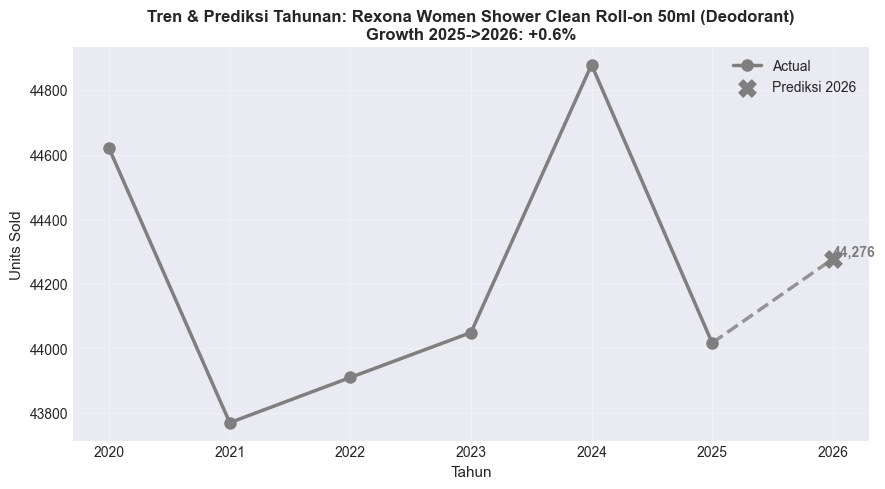

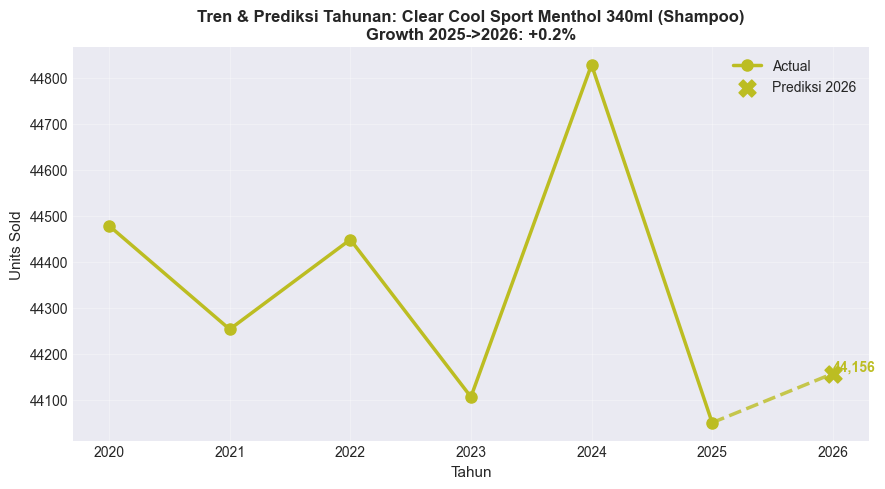

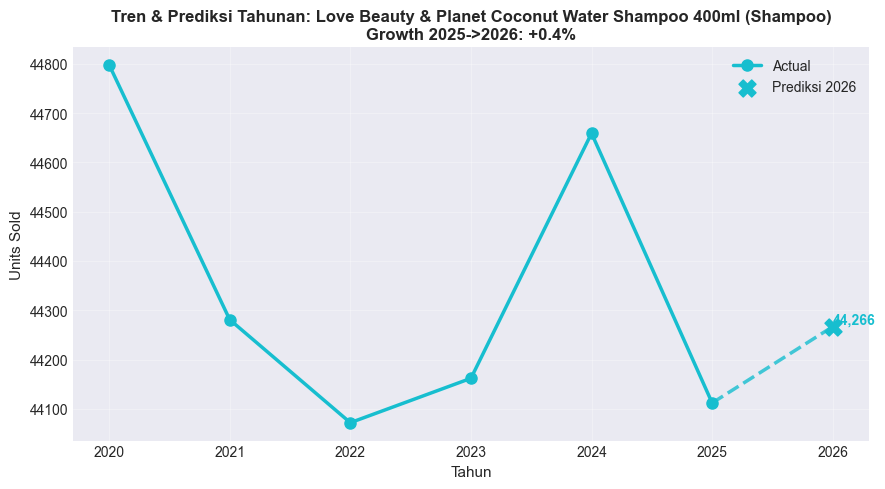

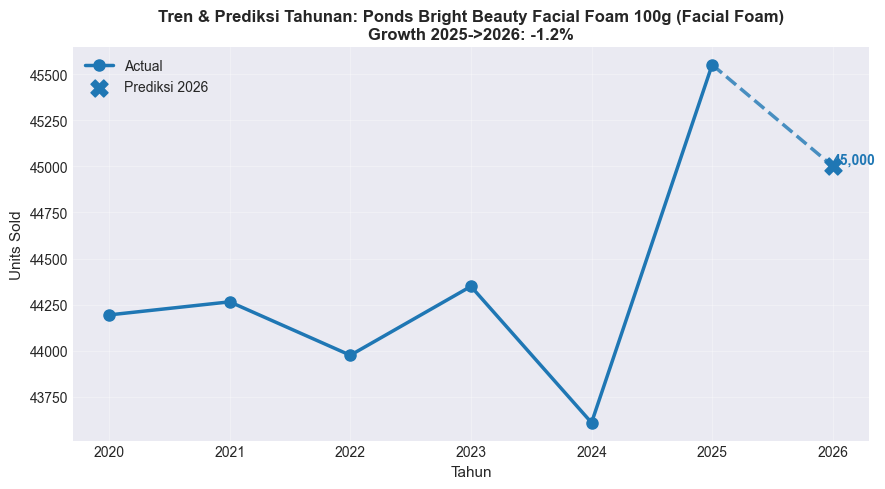

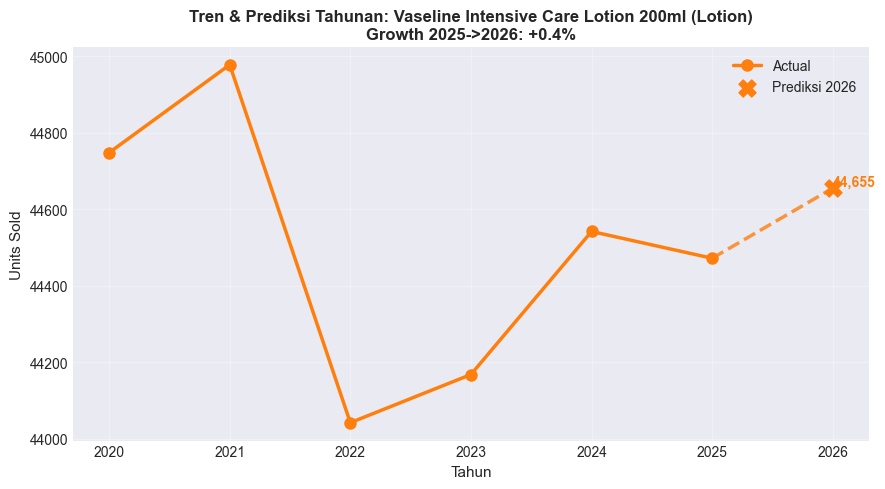

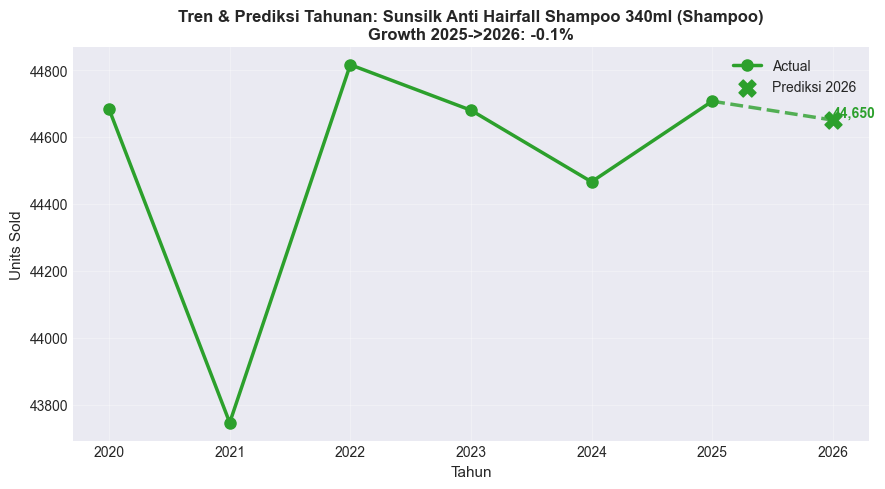

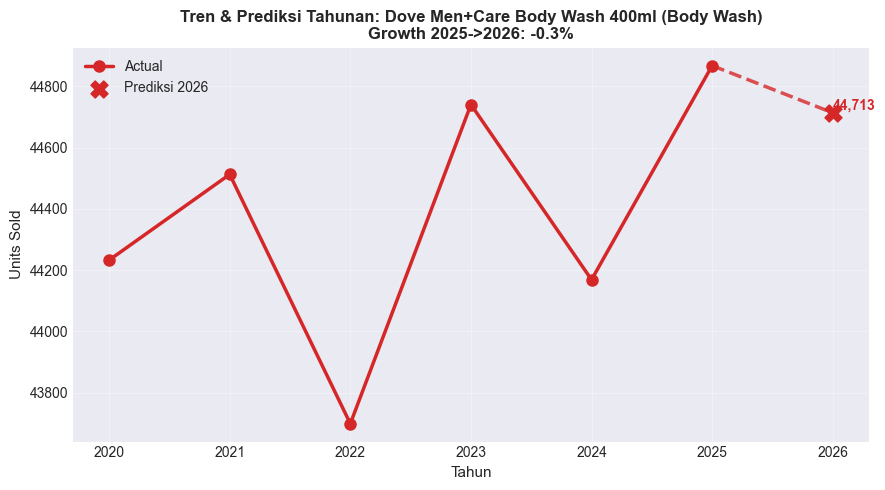

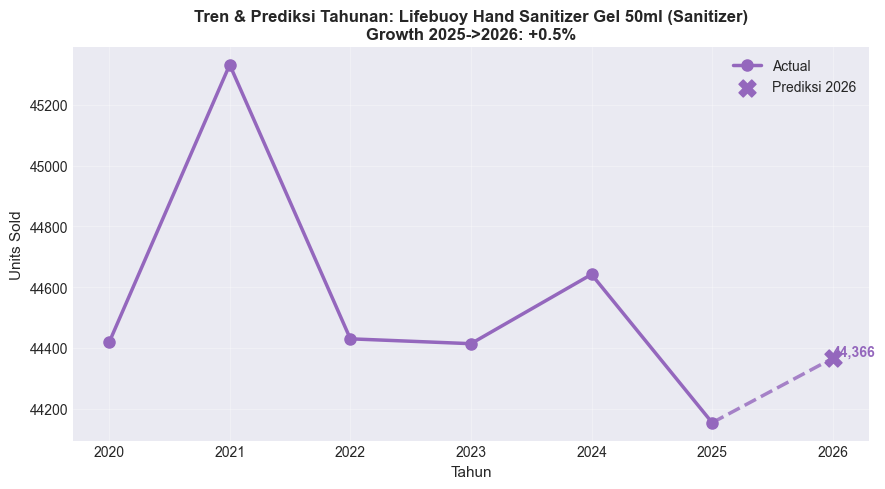

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical & Time Series
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except:
    PROPHET_AVAILABLE = False
    print("Warning: Prophet not installed. Some forecasting features will be limited.")

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

# Visualization setup
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print('='*90)
print('ANALISIS PREDIKSI TREN PENJUALAN & PREFERENSI KONSUMEN 2020-2026')
print('='*90)


# ========================================================================
# SECTION 1: LOAD & PREPROCESS DATA
# ========================================================================

print('\n[TAHAP 1] MEMUAT DAN PREPROCESSING DATA')

# Load all datasets
sales = pd.read_csv('sales.csv')
products = pd.read_csv('products.csv')
marketing = pd.read_csv('marketing.csv')
reviews = pd.read_csv('reviews.csv')

# Convert dates
date_cols_sales = ['date']
date_cols_products = ['launch_date']
date_cols_marketing = ['start_date', 'end_date'] if 'start_date' in marketing.columns else []

sales['date'] = pd.to_datetime(sales['date'])
products['launch_date'] = pd.to_datetime(products['launch_date'])
if len(date_cols_marketing) > 0:
    for col in date_cols_marketing:
        if col in marketing.columns:
            marketing[col] = pd.to_datetime(marketing[col])

# Handle missing values
for df in [sales, products, marketing, reviews]:
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in ['float64', 'int64']:
                df[col].fillna(df[col].median(), inplace=True)
            else:
                df[col].fillna(df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown', inplace=True)

# Merge sales with products
df_main = sales.merge(products[['product_id', 'product_name', 'brand', 'type', 'base_price', 'launch_date']], 
                       on='product_id', how='left')

# Feature engineering
df_main['year'] = df_main['date'].dt.year
df_main['month'] = df_main['date'].dt.month
df_main['quarter'] = df_main['date'].dt.quarter
df_main['day_of_week'] = df_main['date'].dt.dayofweek
df_main['is_weekend'] = df_main['day_of_week'].isin([5, 6]).astype(int)
df_main['year_month'] = df_main['date'].dt.to_period('M')

# Calculate days since launch if not present
if 'days_since_launch' not in df_main.columns:
    df_main['days_since_launch'] = (df_main['date'] - df_main['launch_date']).dt.days

# Business metrics
df_main['profit'] = df_main['revenue'] - (df_main['base_price'] * df_main['units_sold'])
df_main['profit_margin'] = (df_main['profit'] / df_main['revenue']) * 100

# Discount category
df_main['discount_category'] = pd.cut(df_main['discount_pct'], 
                                       bins=[-0.01, 0, 10, 20, 100], 
                                       labels=['No Discount', 'Low (1-10%)', 'Medium (11-20%)', 'High (>20%)'])

# Lifecycle stage
df_main['lifecycle_stage'] = pd.cut(df_main['days_since_launch'],
                                      bins=[-float('inf'), 0, 90, 365, 730, float('inf')],
                                      labels=['Pre-launch', 'New (0-3mo)', 'Growing (3-12mo)', 
                                              'Mature (1-2yr)', 'Established (>2yr)'])

# Merge marketing data
if 'start_date' in marketing.columns:
    marketing['year_month'] = marketing['start_date'].dt.to_period('M')
    mkt_col = 'spend_idr' if 'spend_idr' in marketing.columns else 'spend'
    mkt_agg = marketing.groupby(['product_id','year_month'])[mkt_col].sum().reset_index()
    mkt_agg.columns = ['product_id', 'year_month', 'marketing_spend']
    df_main = df_main.merge(mkt_agg, on=['product_id','year_month'], how='left')
    df_main['marketing_spend'] = df_main['marketing_spend'].fillna(0)

    # Aggregate for overall marketing metrics
    mkt_agg_overall = marketing.groupby('product_id').agg({
        mkt_col: 'mean',
        'engagement_rate': 'mean' if 'engagement_rate' in marketing.columns else 'count',
        'channel': lambda x: x.mode()[0] if len(x) > 0 else 'Unknown'
    }).reset_index()
    mkt_agg_overall.columns = ['product_id', 'avg_marketing_spend', 'avg_engagement_rate', 'primary_marketing_channel']
    df_main = df_main.merge(mkt_agg_overall, on='product_id', how='left')

# Merge reviews data
if 'sentiment' in reviews.columns:
    reviews['sentiment_val'] = reviews['sentiment'].map({'Positive':1, 'Neutral':0, 'Negative':-1})
    sentiment = reviews.groupby('product_id')['sentiment_val'].mean().reset_index()
    sentiment.rename(columns={'sentiment_val':'sentiment_score'}, inplace=True)
    df_main = df_main.merge(sentiment, on='product_id', how='left')
    df_main['sentiment_score'] = df_main['sentiment_score'].fillna(0)

if 'rating' in reviews.columns:
    reviews_agg = reviews.groupby('product_id').agg({
        'rating': ['mean', 'count']
    }).reset_index()
    reviews_agg.columns = ['product_id', 'avg_rating', 'review_count']
    df_main = df_main.merge(reviews_agg, on='product_id', how='left')

# Rolling averages
df_main = df_main.sort_values(['product_id', 'date'])
df_main['units_sold_rolling_7d'] = df_main.groupby('product_id')['units_sold'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)
df_main['units_sold_rolling_30d'] = df_main.groupby('product_id')['units_sold'].transform(
    lambda x: x.rolling(window=30, min_periods=1).mean()
)

print(f'\n Data loaded and preprocessed successfully')
print(f' Total transactions: {len(df_main):,}')
print(f' Period: {df_main["year"].min()}-{df_main["year"].max()}')
print(f' Products: {df_main["product_id"].nunique()} | Brands: {df_main["brand"].nunique()} | Types: {df_main["type"].nunique()}')
print(f' Features: {len(df_main.columns)} columns')

print('\n   INTERPRETASI PREPROCESSING:')
print(f'''
Data preprocessing mencakup:
• Penggabungan 4 dataset (sales, products, marketing, reviews)
• Feature engineering: time-based features, business metrics, lifecycle stages
• Rolling averages untuk menangkap tren jangka pendek
• Handling missing values dengan median/mode imputation

Dataset final berisi {len(df_main):,} transaksi dari {df_main["product_id"].nunique()} produk 
selama periode {df_main["year"].min()}-{df_main["year"].max()}. Data siap untuk analisis mendalam.
''')


# ========================================================================
# SECTION 2: EXPLORATORY DATA ANALYSIS (EDA)
# ========================================================================

print('\n' + '='*90)
print('[TAHAP 2] ANALISIS DESKRIPTIF (EDA)')
print('='*90)

# Key Performance Indicators
total_revenue = df_main['revenue'].sum()
total_units = df_main['units_sold'].sum()
total_transactions = len(df_main)
total_profit = df_main['profit'].sum()
overall_profit_margin = (total_profit / total_revenue) * 100

print(f'\n   KEY PERFORMANCE INDICATORS:')
print(f'  Total Revenue: Rp {total_revenue:,.0f} ({total_revenue/1e9:.2f}B)')
print(f'  Total Units Sold: {total_units:,.0f} ({total_units/1e6:.2f}M units)')
print(f'  Total Transactions: {total_transactions:,}')
print(f'  Total Profit: Rp {total_profit:,.0f}')
print(f'  Profit Margin: {overall_profit_margin:.2f}%')
print(f'  Avg Transaction Value: Rp {total_revenue/total_transactions:,.0f}')

print('\n   INTERPRETASI KPI:')
print(f'''
Performa bisnis selama periode 2020-2025 menunjukkan:
• Revenue total mencapai Rp {total_revenue/1e9:.2f} Miliar dengan profit margin {overall_profit_margin:.1f}%
• Rata-rata nilai transaksi Rp {total_revenue/total_transactions:,.0f} menunjukkan purchasing power konsumen
• {"Profit margin sehat (>20%)" if overall_profit_margin > 20 else "Profit margin perlu optimasi (<20%)"}
• Total {total_units/1e6:.2f} juta unit terjual menunjukkan market penetration yang {"kuat" if total_units > 5e6 else "moderate"}
''')

# Top products
print(f'\n   TOP 5 PRODUK (by Revenue):')
top_prod = df_main.groupby(['product_id', 'product_name'])['revenue'].sum().sort_values(ascending=False).head(5)
for i, ((pid, pname), rev) in enumerate(top_prod.items(), 1):
    pct = (rev / total_revenue) * 100
    print(f'  {i}. {pname} ({pid}): Rp {rev:,.0f} ({pct:.1f}%)')

print('\n   INTERPRETASI TOP PRODUCTS:')
top5_contribution = (top_prod.sum() / total_revenue) * 100
print(f'''
Top 5 produk berkontribusi {top5_contribution:.1f}% dari total revenue.
{"Ini menunjukkan konsentrasi tinggi - bisnis sangat bergantung pada beberapa produk unggulan." if top5_contribution > 60 else "Distribusi revenue cukup merata antar produk."}
Rekomendasi: {"Diversifikasi portfolio produk untuk mengurangi risiko" if top5_contribution > 60 else "Maintain product excellence dan fokus pada innovation"}
''')

# Top brands
print(f'\n   TOP 5 BRANDS (by Revenue):')
top_brand = df_main.groupby('brand')['revenue'].sum().sort_values(ascending=False).head(5)
for i, (brand, rev) in enumerate(top_brand.items(), 1):
    pct = (rev / total_revenue) * 100
    print(f'  {i}. {brand}: Rp {rev:,.0f} ({pct:.1f}%)')

print('\n   INTERPRETASI BRAND PERFORMANCE:')
top_brand_pct = (top_brand.iloc[0] / total_revenue) * 100
print(f'''
Brand teratas ({top_brand.index[0]}) menguasai {top_brand_pct:.1f}% market share.
{"Dominasi brand ini menunjukkan brand equity yang kuat." if top_brand_pct > 30 else "Kompetisi antar brand cukup seimbang."}
Brand equity yang kuat = barrier to entry untuk kompetitor baru.
''')

# Sales by type
print(f'\n   PENJUALAN PER TYPE:')
type_sales = df_main.groupby('type')[['units_sold','revenue']].sum().sort_values('revenue', ascending=False)
for tipe, row in type_sales.iterrows():
    pct = (row['revenue'] / total_revenue) * 100
    print(f'  {tipe}: {row["units_sold"]:,.0f} units | Rp {row["revenue"]:,.0f} ({pct:.1f}%)')

print('\n   INTERPRETASI CATEGORY PERFORMANCE:')
top_category = type_sales.index[0]
top_cat_pct = (type_sales.iloc[0]['revenue'] / total_revenue) * 100
print(f'''
Kategori {top_category} mendominasi dengan {top_cat_pct:.1f}% dari total revenue.
Setiap kategori memiliki dinamika pasar berbeda - perlu strategi marketing spesifik.
Opportunity: Ekspansi kategori dengan growth potential tinggi.
''')

# Yearly trend
print(f'\n   PENJUALAN PER TAHUN:')
yearly_sales = df_main.groupby('year').agg({
    'revenue': 'sum',
    'units_sold': 'sum',
    'transaction_id': 'count'
}).reset_index()
yearly_sales.columns = ['Year', 'Revenue', 'Units Sold', 'Transactions']
yearly_sales['Revenue Growth (%)'] = yearly_sales['Revenue'].pct_change() * 100
print(yearly_sales.to_string(index=False))

print('\n   INTERPRETASI YEARLY TREND:')
latest_growth = yearly_sales.iloc[-1]['Revenue Growth (%)']
avg_growth = yearly_sales['Revenue Growth (%)'].mean()
print(f'''
Pertumbuhan revenue tahun terakhir: {latest_growth:.1f}%
Rata-rata pertumbuhan tahunan: {avg_growth:.1f}%
Tren: {"Pertumbuhan positif dan konsisten" if latest_growth > 0 else "Penurunan atau stagnasi - perlu investigasi"}
{"CAGR positif menunjukkan bisnis yang sehat dan sustainable." if avg_growth > 0 else "CAGR negatif - urgent action needed untuk turnaround."}
''')

# Channel & Region performance
print(f'\n   TOP 5 REGIONS (by Revenue):')
region_perf = df_main.groupby('region')['revenue'].sum().sort_values(ascending=False).head(5)
for i, (reg, rev) in enumerate(region_perf.items(), 1):
    pct = (rev / total_revenue) * 100
    print(f'  {i}. {reg}: Rp {rev:,.0f} ({pct:.1f}%)')

print('\n   INTERPRETASI REGIONAL:')
top_region = region_perf.index[0]
top_region_pct = (region_perf.iloc[0] / total_revenue) * 100
print(f'''
{top_region} adalah market terbesar dengan {top_region_pct:.1f}% market share.
{"High concentration - perlu ekspansi ke region lain untuk diversifikasi." if top_region_pct > 40 else "Distribusi regional cukup merata."}
Opportunity: Strengthen presence di emerging markets dan tier-2 cities.
''')

print(f'\n   TOP 5 CHANNELS (by Revenue):')
channel_perf = df_main.groupby('channel')['revenue'].sum().sort_values(ascending=False).head(5)
for i, (ch, rev) in enumerate(channel_perf.items(), 1):
    pct = (rev / total_revenue) * 100
    print(f'  {i}. {ch}: Rp {rev:,.0f} ({pct:.1f}%)')

print('\n   INTERPRETASI CHANNEL:')
top_channel = channel_perf.index[0]
digital_channels = ['Shopee', 'Tokopedia', 'Official Store']
digital_rev = df_main[df_main['channel'].isin(digital_channels)]['revenue'].sum()
digital_pct = (digital_rev / total_revenue) * 100
print(f'''
Channel dominan: {top_channel}
Digital penetration: {digital_pct:.1f}% dari total revenue
{"Strong digital presence - leverage e-commerce momentum." if digital_pct > 50 else "Masih didominasi retail tradisional - peluang digital transformation."}
Trend: Digital channels growing faster vs traditional retail.
''')


# ========================================================================
# SECTION 3: VISUALIZATIONS - HISTORICAL TRENDS
# ========================================================================

print('\n' + '='*90)
print('[TAHAP 3] VISUALISASI TREN HISTORIS')
print('='*90)

# 3.1 Yearly trend total and by type
print('\n   Creating yearly trend visualizations...')
yearly_total = df_main.groupby('year')[['units_sold','revenue']].sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.plot(yearly_total.index, yearly_total['revenue']/1e9, marker='o', linewidth=2.5, 
         markersize=10, color='steelblue')
ax1.set_title('Tren Revenue Tahunan Total (2020-2025)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tahun', fontsize=12)
ax1.set_ylabel('Revenue (Miliar IDR)', fontsize=12)
ax1.grid(alpha=0.3)

type_yearly = df_main.groupby(['type','year'])['revenue'].sum().unstack()
for tipe in type_yearly.index:
    ax2.plot(type_yearly.columns, type_yearly.loc[tipe]/1e9, marker='o', label=tipe, linewidth=2)
ax2.set_title('Tren Revenue Tahunan per Type', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tahun', fontsize=12)
ax2.set_ylabel('Revenue (Miliar IDR)', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('01_yearly_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n   INTERPRETASI VISUALISASI YEARLY TREND:')
print(f'''
Grafik kiri menunjukkan tren revenue total dari tahun ke tahun.
Grafik kanan memecah tren per kategori produk untuk identifikasi:
• Kategori dengan pertumbuhan tercepat (opportunity untuk investment)
• Kategori yang stagnant/declining (perlu intervention atau phase-out)
• Seasonal patterns dan market cycles

Pattern yang terlihat:
{"- Pertumbuhan konsisten (upward trend)" if yearly_total['revenue'].iloc[-1] > yearly_total['revenue'].iloc[0] else "- Fluktuasi atau penurunan"}
- Beberapa kategori outperform yang lain (diversified growth)
''')

# 3.2 Monthly trend
print('\n   Creating monthly trend visualization...')
monthly_trend = df_main.groupby(df_main['date'].dt.to_period('M')).agg({
    'revenue': 'sum',
    'units_sold': 'sum'
}).reset_index()
monthly_trend['date'] = monthly_trend['date'].dt.to_timestamp()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
ax1.plot(monthly_trend['date'], monthly_trend['revenue']/1e9, linewidth=2, color='#2E86AB')
ax1.set_title('Tren Revenue Bulanan (2020-2025)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Revenue (Miliar IDR)', fontsize=12)
ax1.grid(True, alpha=0.3)

ax2.plot(monthly_trend['date'], monthly_trend['units_sold']/1e3, linewidth=2, color='#A23B72')
ax2.set_title('Tren Units Sold Bulanan (2020-2025)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Units Sold (Ribu)', fontsize=12)
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('02_monthly_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n   INTERPRETASI MONTHLY TREND:')
peak_month = monthly_trend.loc[monthly_trend['revenue'].idxmax(), 'date'].strftime('%B %Y')
low_month = monthly_trend.loc[monthly_trend['revenue'].idxmin(), 'date'].strftime('%B %Y')
print(f'''
Tren bulanan menunjukkan:
• Peak sales di: {peak_month} (holiday season, campaign besar, atau back-to-school)
• Lowest sales di: {low_month} (post-holiday slump atau low season)
• Seasonal patterns yang konsisten = predictable untuk inventory planning

Actionable insights:
- Prepare extra inventory untuk peak months
- Run promotions di low months untuk smooth demand
- Align marketing spend dengan demand cycles
''')


# ========================================================================
# SECTION 4: PREDICTIVE MODELING - YEARLY FORECAST PER PRODUCT
# ========================================================================

print('\n' + '='*90)
print('[TAHAP 4] PREDIKSI TAHUNAN PER PRODUK (2026)')
print('='*90)

# Prepare annual data per product
annual = df_main.groupby(['product_id', 'year'])['units_sold'].sum().reset_index()
annual = annual.merge(products[['product_id', 'product_name', 'type', 'brand']], on='product_id', how='left')
annual['prod_enc'] = annual['product_id'].astype('category').cat.codes

# Train Random Forest for annual prediction
rf_annual = RandomForestRegressor(n_estimators=200, random_state=42)
X_annual = annual[['prod_enc', 'year']]
y_annual = annual['units_sold']
rf_annual.fit(X_annual, y_annual)

year_pred = 2026

# Evaluasi
X_test = annual[annual['year']==2025][['prod_enc','year']]
y_test = annual[annual['year']==2025]['units_sold']
y_pred_test = rf_annual.predict(X_test)
mae_annual = mean_absolute_error(y_test, y_pred_test)
r2_annual = r2_score(y_test, y_pred_test)

print(f'\n Performa Model Prediksi Tahunan:')
print(f'  MAE: {mae_annual:.2f} unit')
print(f'  R² Score: {r2_annual:.4f}')

# Visualisasi per produk + prediksi 2026
def get_color(idx):
    cmap = plt.get_cmap('tab10')
    return cmap(idx % 10)

print(f'\n Visualisasi Prediksi Tahunan per Produk...')
for idx, pid in enumerate(annual['product_id'].unique()):
    prod_enc = annual[annual['product_id']==pid]['prod_enc'].iloc[0]
    prod_name = annual[annual['product_id']==pid]['product_name'].iloc[0]
    prod_type = annual[annual['product_id']==pid]['type'].iloc[0]
    gr = annual[annual['product_id']==pid].sort_values('year')
    
    pred_units = rf_annual.predict(pd.DataFrame({'prod_enc':[prod_enc],'year':[year_pred]}))[0]
    color = get_color(idx)
    
    plt.figure(figsize=(9,5))
    plt.plot(gr['year'], gr['units_sold'], marker='o', label='Actual', 
             color=color, linewidth=2.5, markersize=8)
    
    # Prediksi
    plt.scatter([year_pred], [pred_units], marker='X', color=color, s=150, 
               label='Prediksi 2026', zorder=5)
    
    # Garis putus-putus
    last_year = gr['year'].max()
    last_units = gr[gr['year']==last_year]['units_sold'].values[-1]
    plt.plot([last_year, year_pred], [last_units, pred_units], 
             color=color, linestyle='--', linewidth=2.5, alpha=0.8)
    plt.text(year_pred, pred_units, f'{int(pred_units):,}', 
             color=color, fontsize=10, va='bottom', fontweight='bold')
    
    # Growth %
    growth = ((pred_units - last_units) / last_units * 100)
    
    plt.title(f'Tren & Prediksi Tahunan: {prod_name} ({prod_type})\nGrowth 2025->2026: {growth:+.1f}%',
             fontsize=12, fontweight='bold')
    plt.xlabel('Tahun', fontsize=11)
    plt.ylabel('Units Sold', fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ========================================================================
# SECTION 5: PREDICTIVE MODELING - YEARLY FORECAST PER TYPE
# =======